## PCA base model

The basic model is to create a PCA to reduce the size of pixels in photos. PCA is a popular method that works well for reducing the dimensionality of data. PCA keeps critical information hidden in data through a linear transformation. In photos, this process can be understood as reducing the number of pixels that do not affect key areas of the image.

**Algorithm assumptions**

The PCA algorithm will be built based on the training set and then validated on the test and training sets. The basic assumption of the model is to reduce the dimensionality of the image, and then to compare the pairs of the [anchor, positive] and [anchor, negative] types. This method allows us to determine the average threshold at which the algorithm can determine whether the presented faces in pairs are the same people or not. Then the threshold calculated from the training set will be used to determine whether the face pairs in the training and test sets are the same people or not. This way the accuracy will be calculated and the threshold could be used in the production phase.

**Machine Learning Workflow**

To test different unsupervised algorithms, I will go through several steps:

- Loading data from S3
- Create traning job with build-in PCA algorithm from SageMaker SDK
- Calculate distance threshold with train data
- Validate algorithm with test / val dataset
- Examine results

### Install packages, loading libraries, and create environment variables

In [1]:
# install additional package
!pip install hyperopt

     |████████████████████████████████| 965 kB 20.8 MB/s eta 0:00:01
  Using cached tqdm-4.61.1-py2.py3-none-any.whl (75 kB)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

# sagemaker libraries
import boto3
import sagemaker
from sagemaker import get_execution_role

# s3fs library imports and creates s3 object
from s3fs.core import S3FileSystem
s3 = S3FileSystem()


import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Loading data from S3

This dataset is already in an Amazon S3 bucket, it was created in the first stage notebook where we explore and dump the dataset to local storage and s3.

In [3]:
# boto3 client to get S3 data
s3_client = boto3.client('s3')
# S3 bucket name

sagemaker_session = sagemaker.Session()

# get default data bucket
bucket = sagemaker_session.default_bucket()
# create prefix for pca algorithm job
prefix_pca_output = 'ml_capstone/face_recognition_pca'

prefix_pca_input = f'{bucket}/ml_capstone/face_recognition'

# get IAM role
role = get_execution_role()
print('Role used by SageMaker: ', role)
print('Default S3 bucket: ', bucket)

Role used by SageMaker:  arn:aws:iam::081489346219:role/c20300a265023u1343687t1w0-SageMakerNotebookInstanc-YHJZOL3CFWPI
Default S3 bucket:  sagemaker-us-east-1-081489346219


## Create traning job with build-in PCA algorithm from SageMaker SDK

The Amazon SageMaker PCA algorithm is the build-in algorithm that can be used for any type of data. Below, a basic fitting method is described. We can add the number of components for PCA, subtract the mean (which normalizes the data) as parameters. Furthermore, we can add mode, instance type, and spot instance. Spot Instances let us take advantage of unused EC2 capacity in the AWS cloud. Spot Instances are available at up to a 90% discount compared to On-Demand prices.

In [4]:
# define a PCA model
from sagemaker import PCA

N_COMPONENTS=150
output_path = f's3://{bucket}/{prefix_pca_output}'


pca_SM = PCA(role=role,
             instance_count=1,
             instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS,
             sagemaker_session=sagemaker_session,
             mode='randomized',
             subtract_mean=True,
             use_spot_instances=True,
             max_run=3600,
             max_wait=3600)

### Convert data into a RecordSet format

Next, prepare the data for a built-in model by converting the Numpy array to **RecordSet**.

The record_set function in the SageMaker PCA model converts a NumPy array into a RecordSet format that is the required format for the training input data. This is a requirement for all of SageMaker's built-in models.

In [5]:
# convert numpy array to record set
train_data = np.load(s3.open(f'{prefix_pca_input}/X_train_pca.npy')).astype('float32')
formatted_train_data = pca_SM.record_set(train_data[:, 0, :])

### Train the model

Now we can call the fit function on the PCA model, passing in formatted, training data.

In [6]:
%%time
# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data, wait=True)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-06-29 19:27:46 Starting - Starting the training job...
2021-06-29 19:28:11 Starting - Launching requested ML instancesProfilerReport-1624994866: InProgress
...
2021-06-29 19:28:50 Starting - Preparing the instances for training............
2021-06-29 19:30:47 Downloading - Downloading input data...
2021-06-29 19:31:20 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/29/2021 19:31:24 INFO 140211638945600] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[06/29/2021 19:31:24 INFO 140211638945600] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim

#metrics {"StartTime": 1624995085.79339, "EndTime": 1624995092.170641, "Dimensions": {"Algorithm": "PCA", "Host": "algo-1", "Operation": "training"}, "Metrics": {"finalize.time": {"sum": 6376.468658447266, "count": 1, "min": 6376.468658447266, "max": 6376.468658447266}}}

[06/29/2021 19:31:32 INFO 140211638945600] Test data is not provided.
#metrics {"StartTime": 1624995092.1707315, "EndTime": 1624995092.1750827, "Dimensions": {"Algorithm": "PCA", "Host": "algo-1", "Operation": "training"}, "Metrics": {"setuptime": {"sum": 22.950172424316406, "count": 1, "min": 22.950172424316406, "max": 22.950172424316406}, "totaltime": {"sum": 7720.877885818481, "count": 1, "min": 7720.877885818481, "max": 7720.877885818481}}}


2021-06-29 19:31:43 Uploading - Uploading generated training model
2021-06-29 19:31:43 Completed - Training job completed
Training seconds: 56
Billable seconds: 17
Managed Spot Training savings: 69.6%
CPU times: user 542 ms, sys: 31.9 ms, total: 574 ms
Wall time: 4min 15s


### Deploy the PCA Model

We can now deploy the PCA model and use it to make predictions. 

In [7]:
# this takes a little while, around 7mins
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------!

### Predict based on endpoint

Based on the endpoint that we have created, we can transform the images into a PCA vector with a specified number of components. Since we have put the algorithm on a relatively small instance, we will perform the batch predictions with a certain number of requests. Moreover, the algorithm returns an object in the form of a RecordSet, so we have to convert the output to a NumPy array.

To correctly determine the threshold, we make predictions on anchor images, and then on positive/negative pair, thus will be able to determine the threshold for which we assume that a given face is the same as the base face.

In [8]:
def _pb_to_numpy(pb_object):
    return pb_object.label['projection'].float32_tensor.values

def batch_prediction(data, predictor, embedding_size, batch_size=100):
    numpy_frame = np.zeros((data.shape[0], embedding_size))
    for bs in range(0, data.shape[0], batch_size):
        # predict using endpoints
        batch_prediction = predictor.predict(data[bs:bs+batch_size])
        numpy_frame[bs:bs+batch_size] = np.array(list(map(_pb_to_numpy, batch_prediction)))
    return numpy_frame

train_pca_anchor = batch_prediction(train_data[:, 0, :], pca_predictor, N_COMPONENTS)
train_pca_samples = batch_prediction(train_data[:, 1, :], pca_predictor, N_COMPONENTS)
train_labels = np.load(s3.open(f'{prefix_pca_input}/y_train_pca.npy'))

print(f'Train data anchors shape: {train_pca_anchor.shape}')
print(f'Train data samples shape: {train_pca_samples.shape}')
print(f'Train data labels shape: {train_labels.shape}')

Train data anchors shape: (2032, 150)
Train data samples shape: (2032, 150)
Train data labels shape: (2032,)


## Calculate distance threshold with train data

For the threshold estimation, the hyperopt library was used. Hyperopt is a Python library for serial and parallel optimization over awkward search spaces, which may include real-valued, discrete, and conditional dimensions. To compare vectors euclidean distance as used. Moreover, optimization was conducted base on the minimization function described above. As mentioned before, algorithms create embeddings for each image and estimate thresholds based on distance. The threshold obtained in this way will be used to check the metrics for the test and validation sets.

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, cohen_kappa_score, precision_score
# import hyperopt libraries
from hyperopt import fmin, tpe, hp, Trials, space_eval


def calculate_distances(anchor_embedding, sample_embedding, metric='euclidean'):
    # calculate distance between anchor and sample with given metric
    metrics = ['euclidean', 'cosine']
    # calcyulate pairwise euclidean distance
    if metric == metrics[0]:
        return np.linalg.norm(anchor_embedding-sample_embedding, axis=1)
    # calculate cosine distance
    elif metric == metrics[1]:
        return 1 - np.diag(cosine_similarity(anchor_embedding, sample_embedding), k=0)
    else:
        raise ValueError(f'{metric} not implemented, use one of {metrics} metrics')


def scorer(y, y_sim):
    # create dictionary with basic metrics
    func = [accuracy_score, f1_score, roc_auc_score, cohen_kappa_score]
    names = ['Accuracy', 'F1', 'ROC_AUC', 'COHEN_KAPPA']
    score = dict()
    for f, name in zip(func, names):
        score[name] = f(y, y_sim)

    return score


def threshold_optimization(dataset, labels, threshold_max, max_evals):
    ## Create optimization threshold function

    def minimize(threshold):
        # minimize function with given threshold
        binary_score = np.where(data < threshold, 1, 0)
        return 1-accuracy_score(labels, binary_score)

    # optimize the threshold based on f1 metric
    best = fmin(fn=minimize,
        space=hp.uniform('threshold', 0, threshold_max),
        algo=tpe.suggest,
        max_evals=max_evals,
        rstate = np.random.RandomState(1))
    
    thresh = int(best['threshold'])
    
    acc = accuracy_score(labels, np.where(data < thresh, 1, 0))
    print(f'Best threshold: {thresh}')
    print(f'Accuracy score {acc}')
    return thresh

In [10]:
# calculate optimal threshold with eclidean metric
data = calculate_distances(train_pca_anchor, train_pca_samples, metric='euclidean')
threshold = threshold_optimization(data, train_labels, 10000, 100)

100%|██████████| 100/100 [00:00<00:00, 283.60trial/s, best loss: 0.41240157480314965]
Best threshold: 2566
Accuracy score 0.5875984251968503


## Validate algorithm with test / val dataset

In [11]:
np.load(s3.open(f'{prefix_pca_input}/X_train_pca.npy')).astype('float32')

test_data = np.load(s3.open(f'{prefix_pca_input}/X_test_pca.npy')).astype('float32')

test_pca_anchor = batch_prediction(test_data[:, 0, :], pca_predictor, N_COMPONENTS)
test_pca_samples = batch_prediction(test_data[:, 1, :], pca_predictor, N_COMPONENTS)
test_labels = np.load(s3.open(f'{prefix_pca_input}/y_test_pca.npy'))

print(f'Train data anchors shape: {test_pca_anchor.shape}')
print(f'Train data samples shape: {test_pca_samples.shape}')
print(f'Train data labels shape: {test_labels.shape}')


test_distances = calculate_distances(test_pca_anchor, test_pca_samples, metric='euclidean')

scorer(test_labels, np.where(test_distances < threshold, 1, 0))

Train data anchors shape: (508, 150)
Train data samples shape: (508, 150)
Train data labels shape: (508,)


{'Accuracy': 0.6023622047244095,
 'F1': 0.547085201793722,
 'ROC_AUC': 0.6023622047244095,
 'COHEN_KAPPA': 0.20472440944881887}

In [12]:
validation_data = np.load(s3.open(f'{prefix_pca_input}/X_val_final.npy')).astype('float32')

val_pca_anchor = batch_prediction(validation_data[:, 0, :], pca_predictor, N_COMPONENTS)
val_pca_samples = batch_prediction(validation_data[:, 1, :], pca_predictor, N_COMPONENTS)
val_labels = np.load(s3.open(f'{prefix_pca_input}/y_val_final.npy'))

print(f'Train data anchors shape: {val_pca_anchor.shape}')
print(f'Train data samples shape: {val_pca_samples.shape}')
print(f'Train data labels shape: {val_labels.shape}')


val_distances = calculate_distances(val_pca_anchor, val_pca_samples, metric='euclidean')

scorer(val_labels, np.where(val_distances < threshold, 1, 0))

Train data anchors shape: (254, 150)
Train data samples shape: (254, 150)
Train data labels shape: (254,)


{'Accuracy': 0.5826771653543307,
 'F1': 0.5137614678899082,
 'ROC_AUC': 0.5826771653543308,
 'COHEN_KAPPA': 0.16535433070866146}

## Examine results

We can see the results for the test, training, and validation set are similar, which means that our model, but also the selected threshold, is correct. 

The PCA base model achieved **0.58 accuracy** for the validation set. Furthermore, the PCA model is easy to interpret and maintain. This is a huge advantage of this type of model, but the accuracy is not sufficient to implement the model into production. 

The PCA model does not to be able to diagnose the improvement in the facial shift in the image. We can use this model as a baseline to obtain a view of the dataset and prediction. Below histograms with distance thresholds are analyzed. We see that some faces are far away from the minimum distance threshold. This can lead to incorrect authorization with users especially in cases of different angles of the face. 

In [15]:
import seaborn as sns

def make_plot(distance, labels):
    df = pd.DataFrame({'distance': distance, 'labels': labels})
    sns.displot(df, x='distance', kde=True, col='labels')
    plt.show()

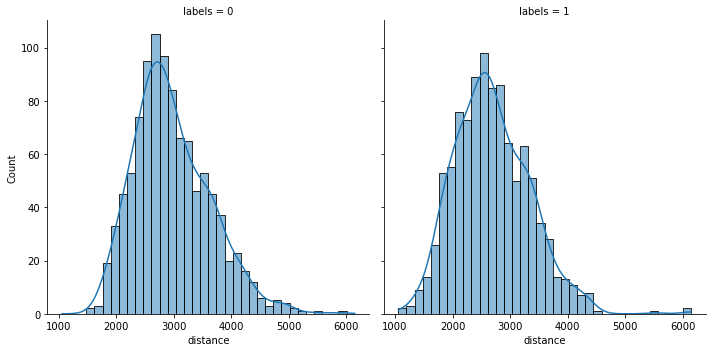

In [16]:
make_plot(data, train_labels)

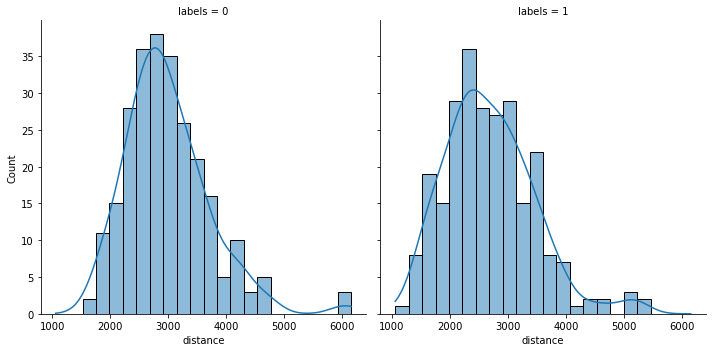

In [17]:
make_plot(test_distances, test_labels)

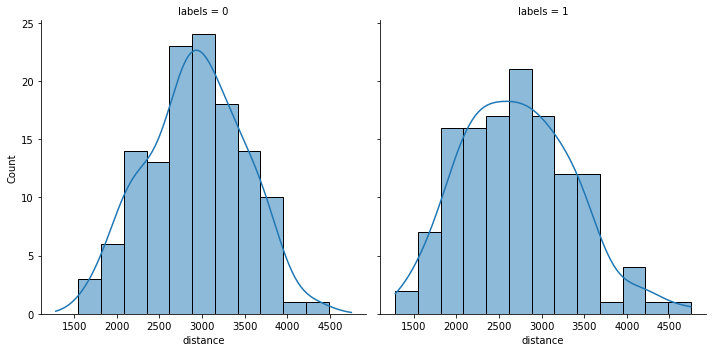

In [18]:
make_plot(val_distances, val_labels)

In [19]:
pca_predictor.delete_endpoint()